In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle

In [2]:
df = pd.read_csv("data/news_w_sentiment2.csv")

## Market Trends: Pretrained FinBERT (FinBERT-LSTM)

In [3]:
# Load pre-merged dataset of news and price data
price_df = pd.read_csv("data/price.csv")
news_df = pd.read_csv("data/news.csv")

price_df["daily_return"] = price_df.groupby("ticker")["close"].transform(
    lambda x: x.pct_change()
)
price_df = price_df.dropna()

# Convert dates to datetime
news_df["publication_datetime"] = pd.to_datetime(news_df["publication_datetime"])
price_df["Date"] = pd.to_datetime(price_df["Date"])

price_df = price_df.sort_values(["ticker", "Date"])
price_df["daily_return"] = price_df.groupby("ticker")["close"].pct_change()

news_w_sentiments = pd.read_csv("data/news_w_sentiment2.csv")

news_w_sentiments.head()

,publication_datetime,title,body,tickers,FinBERT score,VADER score,combined_sentiment
0,2017-01-03,World News: Police Question Netanyahu Over Gifts,"""We pay attention to publications in the media...",EL,-0.999937,1.000,0.000031
1,2017-01-03,Business News: Nestle Turns to New CEO for Hea...,"Nestle, the world's largest packaged-food comp...",GIS,0.000000,1.000,0.500000
2,2017-01-03,Business News: Vermont Drug Law Faces Limits -...,"The Vermont law, enacted in June, instructed s...",ABBV,-0.999891,1.000,0.000054
3,2017-01-03,Life & Arts -- Travel: How Hotel Companies Lau...,Travelers are about to see a flurry of new hot...,HLT,-0.999991,1.000,0.000005
4,2017-01-03,Businesses Ready to Ramp Up Investment --- Aft...,The Federal Reserve last month signaled intere...,HD,-0.984549,0.894,-0.045275


In [4]:
news_df_test = news_w_sentiments.loc[
    news_df["publication_datetime"] >= "2020-01-01"
].copy()

news_df_test["publication_datetime"] = pd.to_datetime(
    news_w_sentiments["publication_datetime"]
)
monthly_sentiment = (
    news_df_test.groupby(news_df_test["publication_datetime"].dt.to_period("m"))[
        "combined_sentiment"
    ]
    .mean()
    .reset_index()
)
monthly_sentiment.columns = ["month", "combined_sentiment"]

C:\Users\drebi\AppData\Local\Temp\ipykernel_35148\3516482256.py:9: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'M' instead.
  news_df_test.groupby(news_df_test["publication_datetime"].dt.to_period("m"))[


In [5]:
def calculate_sp_return(month):
    current_period = price_df.loc[
        (price_df["Date"] >= month.start_time)
        & (price_df["Date"] < (month + 1).start_time)
        & (price_df["ticker"] == "SPX")
    ]

    next_period = price_df.loc[
        (price_df["Date"] >= (month + 1).start_time)
        & (price_df["Date"] < (month + 2).start_time)
        & (price_df["ticker"] == "SPX")
    ]

    if not current_period.empty and not next_period.empty:
        return (current_period["close"].iloc[-1] / next_period["close"].iloc[-1]) - 1
    else:
        return None

In [6]:
# monthly return for S&P500; the return is calculated based on the close price at the last trading date of the current month and that of the next month
monthly_sentiment["SP_return"] = monthly_sentiment["month"].apply(calculate_sp_return)

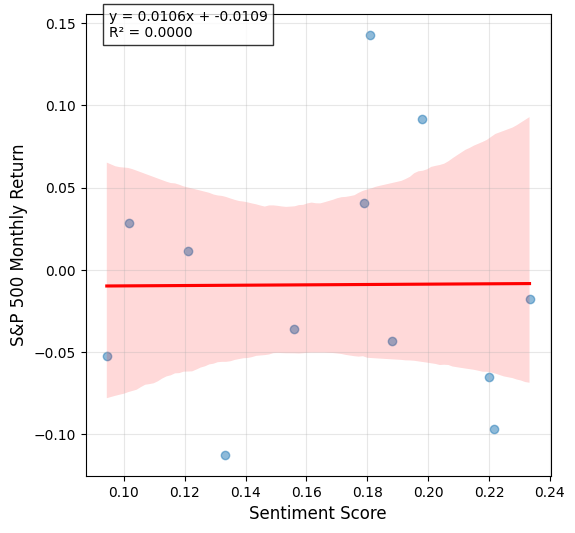


Regression Statistics:
R-squared: 0.0000
P-value: 0.9837
Slope: 0.0106
Intercept: -0.0109
Standard Error: 0.5046


In [7]:
# Create the regression plot
plt.figure(figsize=(6, 6))
sns.regplot(
    x="combined_sentiment",
    y="SP_return",
    data=monthly_sentiment,
    scatter_kws={"alpha": 0.5},  # Make points slightly transparent
    line_kws={"color": "red"},
)  # Make regression line red

# Add labels and title
plt.xlabel("Sentiment Score", fontsize=12)
plt.ylabel("S&P 500 Monthly Return", fontsize=12)
plt.grid(True, alpha=0.3)

# Calculate and display regression statistics
slope, intercept, r_value, p_value, std_err = stats.linregress(
    monthly_sentiment["combined_sentiment"], monthly_sentiment["SP_return"]
)

# Add regression equation to plot
equation = f"y = {slope:.4f}x + {intercept:.4f}"
r_squared = f"R² = {r_value**2:.4f}"
plt.text(
    0.05,
    0.95,
    f"{equation}\n{r_squared}",
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="white", alpha=0.8),
)

plt.show()

# Print detailed statistics
print("\nRegression Statistics:")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"Standard Error: {std_err:.4f}")

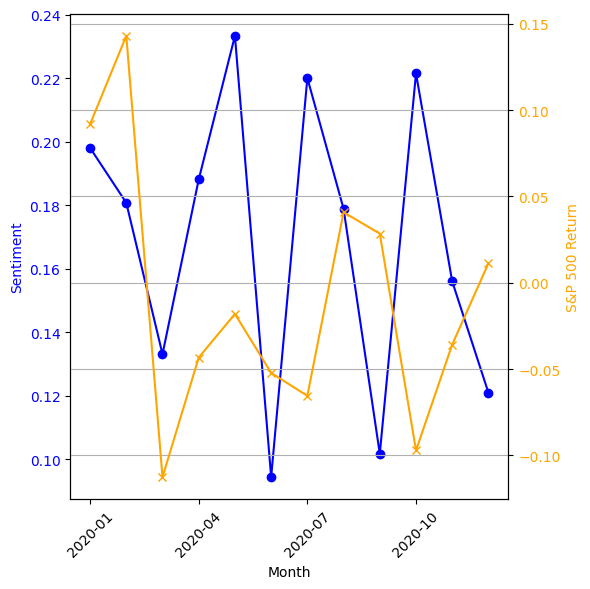

In [8]:
fig, ax1 = plt.subplots(figsize=(6, 6))

# Convert 'month' to a string format for plotting
ax1.set_xlabel('Month')
ax1.set_ylabel('Sentiment', color='blue')
ax1.plot(monthly_sentiment['month'].astype(str), monthly_sentiment['combined_sentiment'], label='Sentiment', color='blue', marker='o')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the S&P 500 return
ax2 = ax1.twinx()  
ax2.set_ylabel('S&P 500 Return', color='orange')  
ax2.plot(monthly_sentiment['month'].astype(str), monthly_sentiment['SP_return'], label='S&P 500 Return', color='orange', marker='x')
ax2.tick_params(axis='y', labelcolor='orange')

# Reduce x-axis ticks by showing every nth month
n = 3  # Show every 3rd month
months = monthly_sentiment['month'].astype(str)
ax1.set_xticks(months[::n])  # Set ticks for every nth month
ax1.set_xticklabels(months[::n], rotation=45)

fig.tight_layout()  
plt.grid(True)
plt.show()

## Market Trends: Fine-Tuned BERT (Experiment D)

In [9]:
# Load the sentiment scores from the pickle file
with open('scores/sentiment_scores_D.pkl', 'rb') as f:
    sentiment_scores = pickle.load(f)

news_df_test = news_df.loc[news_df['publication_datetime'] >= '2020-01-01'].copy()
news_df_test.loc[:, 'sentiment'] = sentiment_scores

# monthly sentiment
news_df_test['publication_datetime'] = pd.to_datetime(news_df_test['publication_datetime'])
monthly_sentiment = news_df_test.groupby(news_df_test['publication_datetime'].dt.to_period('M'))['sentiment'].mean().reset_index(name='sentiment')
monthly_sentiment.columns = ['month', 'sentiment']


def calculate_sp_return(month):
    current_period = price_df.loc[
        (price_df['Date'] >= month.start_time) & 
        (price_df['Date'] < (month + 1).start_time) & 
        (price_df['ticker'] == 'SPX')
    ]
    
    next_period = price_df.loc[
        (price_df['Date'] >= (month + 1).start_time) & 
        (price_df['Date'] < (month + 2).start_time) & 
        (price_df['ticker'] == 'SPX')
    ]
    
    if not current_period.empty and not next_period.empty:
        return (current_period['close'].iloc[-1] / next_period['close'].iloc[-1]) - 1
    else:
        return None

monthly_sentiment['SP_return'] = monthly_sentiment['month'].apply(calculate_sp_return)

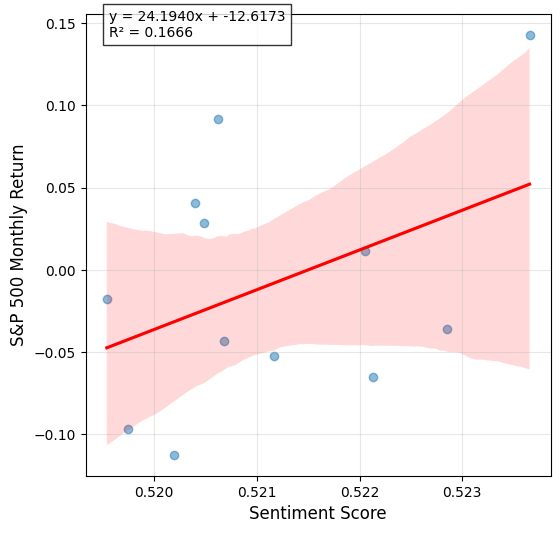


Regression Statistics:
R-squared: 0.1666
P-value: 0.1878
Slope: 24.1940
Intercept: -12.6173
Standard Error: 17.1131


In [10]:

# Regression Analysis

# Create the regression plot
plt.figure(figsize=(6, 6))
sns.regplot(x='sentiment', y='SP_return', data=monthly_sentiment,
            scatter_kws={'alpha':0.5},  # Make points slightly transparent
            line_kws={'color':'red'})   # Make regression line red

# Add labels and title
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('S&P 500 Monthly Return', fontsize=12)
plt.grid(True, alpha=0.3)

# Calculate and display regression statistics
slope, intercept, r_value, p_value, std_err = stats.linregress(monthly_sentiment['sentiment'], monthly_sentiment['SP_return'])

# Add regression equation to plot
equation = f'y = {slope:.4f}x + {intercept:.4f}'
r_squared = f'R² = {r_value**2:.4f}'
plt.text(0.05, 0.95, f'{equation}\n{r_squared}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

# Print detailed statistics
print("\nRegression Statistics:")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"Standard Error: {std_err:.4f}")

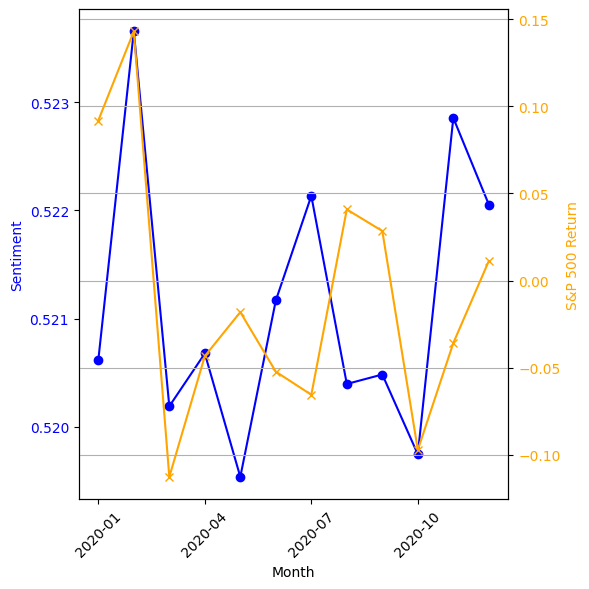

In [11]:

fig, ax1 = plt.subplots(figsize=(6, 6))

# Convert 'month' to a string format for plotting
ax1.set_xlabel('Month')
ax1.set_ylabel('Sentiment', color='blue')
ax1.plot(monthly_sentiment['month'].astype(str), monthly_sentiment['sentiment'], label='Sentiment', color='blue', marker='o')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the S&P 500 return
ax2 = ax1.twinx()  
ax2.set_ylabel('S&P 500 Return', color='orange')  
ax2.plot(monthly_sentiment['month'].astype(str), monthly_sentiment['SP_return'], label='S&P 500 Return', color='orange', marker='x')
ax2.tick_params(axis='y', labelcolor='orange')

# Reduce x-axis ticks by showing every nth month
n = 3  # Show every 3rd month
months = monthly_sentiment['month'].astype(str)
ax1.set_xticks(months[::n])  # Set ticks for every nth month
ax1.set_xticklabels(months[::n], rotation=45)

fig.tight_layout()  
plt.grid(True)
plt.xticks(rotation=45)
plt.show()